<p> <marquee ><font size="19" face="Segoe Script" color="#007C80"> Practical Lab 10</font></p>
</marquee>

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

In [34]:


# Get dataset
# find 3 classes with the highest number of images

# use train data to find
train_folder = pathlib.Path("C://Users//krath//ML_Foundation//archive//train")

#train_folder = pathlib.Path('../data/birds/train')
test_folder = pathlib.Path("C://Users//krath//ML_Foundation//archive//test")
valid_folder = pathlib.Path("C://Users//krath//ML_Foundation//archive//valid")
train_folder
#test_folder
#valid_folder



WindowsPath('C:/Users/krath/ML_Foundation/archive/train')

In [35]:
# dict to store image count for each class
image_count = {}

# Loop through sub directories and update the count for each class
for species in os.listdir(train_folder):
    species_path = os.path.join(train_folder, species)
    if os.path.isdir(species_path):
        image_count[species] = len(os.listdir(species_path))

# sort the dictionary to list 3 top class
top_3_class = sorted(image_count, key=image_count.get, reverse=True)[:3]

print('Top 3 class with highest number of images:', top_3_class)

Top 3 class with highest number of images: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [36]:
top_3_class = ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

def remove_folder(dir_path):
    for entry in os.scandir(dir_path):
        if entry.is_file():
            os.remove(entry.path)
        elif entry.is_dir() and entry.name not in top_3_class:
            # recursively call the function to remove the files inside
            remove_folder(entry.path)
            # remove empty folder after removing files
            os.rmdir(entry.path)

# Paths to the directories
train_path = "C://Users//krath//ML_Foundation//archive//train"
test_path = "C://Users//krath//ML_Foundation//archive//test"
validation_path = "C://Users//krath//ML_Foundation//archive//valid"

# Call the function for three folders
remove_folder(train_path)
remove_folder(test_path)
remove_folder(validation_path)


2- Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [37]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(train_path, image_size=(224,224), batch_size=32)
validation_data = image_dataset_from_directory(validation_path, image_size=(224,224), batch_size=32)
test_data = image_dataset_from_directory(test_path, image_size=(224,224), batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


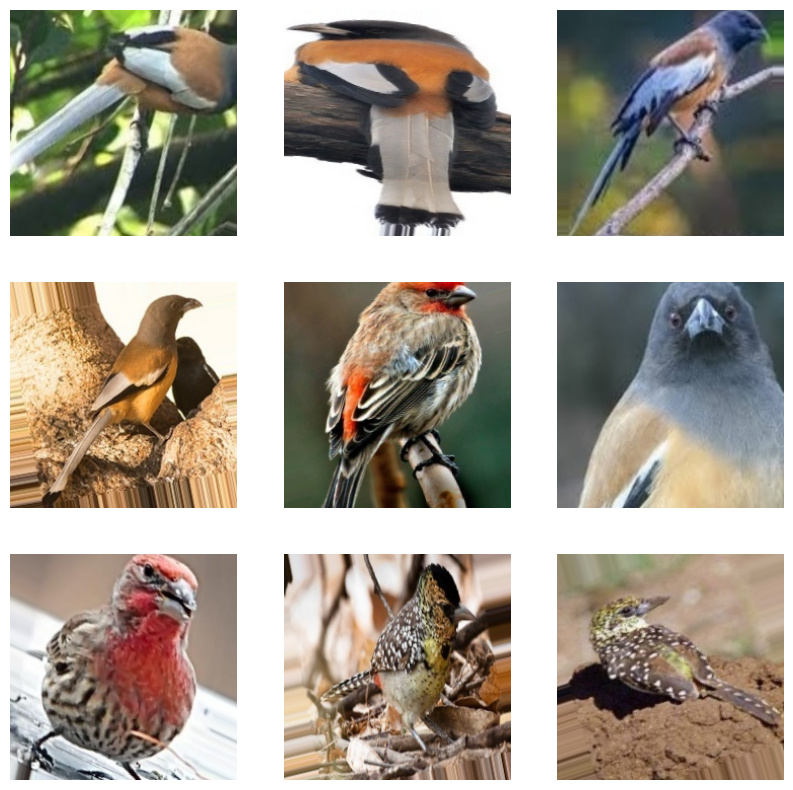

In [38]:
#from keras.preprocessing.image import ImageDataGenerator

augmented_data = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_data_generator = ImageDataGenerator(rescale = 1.0/255)

train_generator = augmented_data.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = augmented_data.flow_from_directory(
    validation_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# display some augmented training images

# get images and labels from train_generator
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

3 - Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes (2 points)

In [39]:
# load pre-trained VGG16 model from imagenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [40]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)


predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [43]:

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [44]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [45]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 342s 14s/step - loss: 1.3685 - accuracy: 0.8239 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 308s 13s/step - loss: 0.4548 - accuracy: 0.9449 - val_loss: 3.6824e-04 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 346s 14s/step - loss: 0.1912 - accuracy: 0.9677 - val_loss: 7.0013e-06 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 341s 14s/step - loss: 0.0970 - accuracy: 0.9758 - val_loss: 1.3088e-05 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 299s 12s/step - loss: 0.0989 - accuracy: 0.9825 - val_loss: 1.2874e-06 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 305s 13s/step - loss: 0.0962 - accuracy: 0.9839 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 332s 14s/step - loss: 0.1892 - accuracy: 0.9637 - val_loss: 9.7205e-05 - val_acc

4 - Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

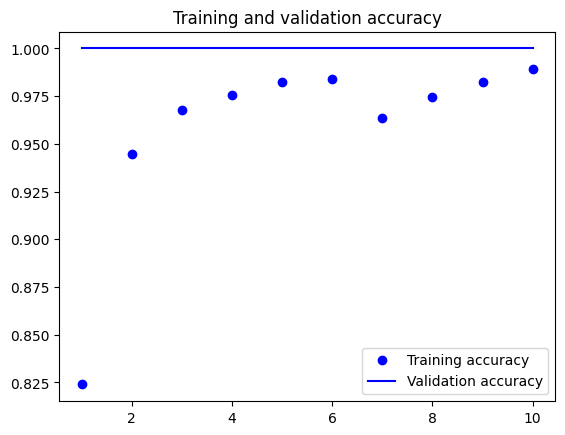

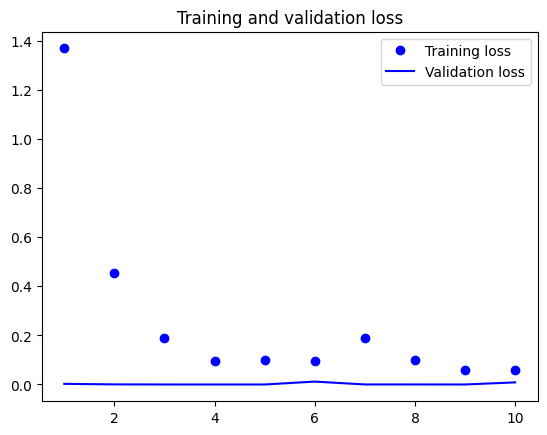

In [46]:

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [47]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 6s 6s/step - loss: 0.0015 - accuracy: 1.0000
Test accuracy: 1.000


In [48]:

y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_class)

print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 7s 7s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.60      0.60      0.60         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.20      0.20      0.20         5

        accuracy                           0.33        15
       macro avg       0.33      0.33      0.33        15
    weighted avg       0.33      0.33      0.33        15



1/1 [==============================] - 6s 6s/step


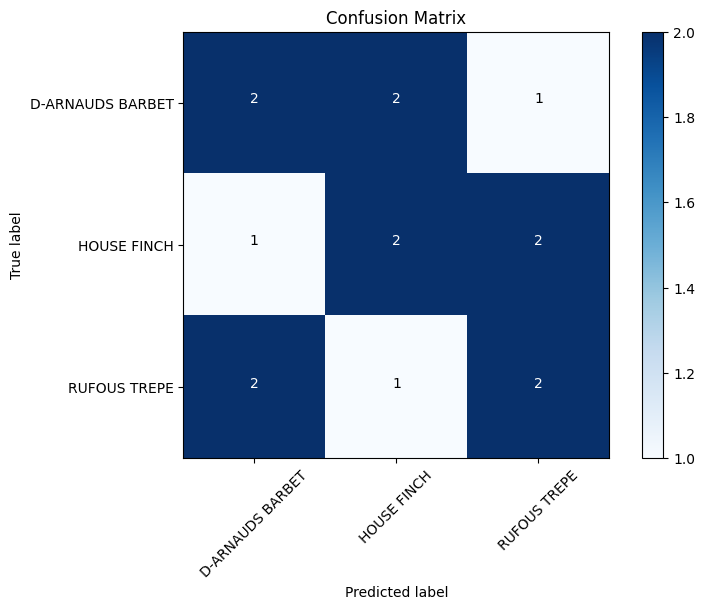

Classification Report:
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.40      0.40      0.40         5
     HOUSE FINCH       0.40      0.40      0.40         5
    RUFOUS TREPE       0.40      0.40      0.40         5

        accuracy                           0.40        15
       macro avg       0.40      0.40      0.40        15
    weighted avg       0.40      0.40      0.40        15



In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Replace these with your actual model predictions and true labels
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall, and F1-score
report = classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys())

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=validation_generator.class_indices.keys(), title='Confusion Matrix')

# Display precision, recall, and F1-score
print("Classification Report:")
print(report)


AUC for D-ARNAUDS BARBET: 0.5346520146520146
AUC for HOUSE FINCH: 0.5252380952380953
AUC for RUFOUS TREPE: 0.5170787545787545


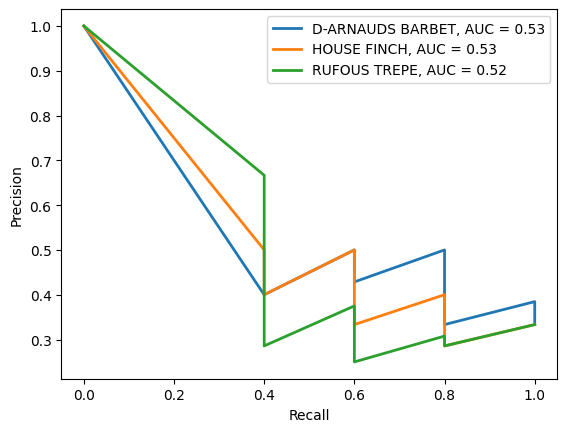

In [65]:
# convert true labels to one-hot encoding for multi-class
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()